# Decision tree for 0MA+enumeration queries
## SparkSQL, basic features+POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [73]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [114]:
file_path = 'results/features_times_SPA_extra_full_enum_infos.csv'
df1 = pd.read_csv(file_path)
df1['0ma'] = 0

In [120]:
file_path = 'results/features_times_SPA_infos.csv'
df2 = pd.read_csv(file_path)
df2_features = pd.read_csv('results/features_times_POS_extra_infos.csv')
df2_features = df2_features[['query', 'total cost', 'min(table rows)', 'max(table rows)', 'mean(table rows)', 'q25(table rows)', 'median(table rows)', 'q75(table rows)', 'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)', 'median(join rows)', 'q75(join rows)']]

df2 = pd.merge(df2, df2_features, on = 'query', how='inner')

df2['0ma'] = 1

In [121]:
cols = ['bench', 'query', 'orig/rewr(med)', 'orig(med)', 'rewr(med)',
        '0ma',
       '#joins', 'total cost', 'min(table rows)', 'max(table rows)',
       'mean(table rows)', 'q25(table rows)', 'median(table rows)',
       'q75(table rows)', 'min(join rows)', 'max(join rows)',
       'mean(join rows)', 'q25(join rows)', 'median(join rows)',
       'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)']

In [122]:
df1 = df1[cols]
df2 = df2[cols]
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

bench                query orig/rewr(med)             orig(med)  \
0  STATS        001-014-full1           orig   0.03788018226623535   
1  STATS        001-014-full2           orig   0.03778505325317383   
2  STATS        001-014-full3           orig  0.038272857666015625   
3  STATS  001-014-augF1-full1           orig   0.03761172294616699   
4  STATS  001-014-augF1-full2           orig   0.03772568702697754   

             rewr(med)  0ma  #joins  total cost  min(table rows)  \
0  0.08295345306396484    0       2    11475.41                1   
1  0.08245158195495605    0       2    11475.41                1   
2  0.08548593521118164    0       2    11475.41                1   
3  0.08422040939331055    0       2    11412.99                1   
4  0.08310413360595703    0       2    11412.99                1   

   max(table rows)  ...  mean(container counts)  q25(container counts)  \
0           168966  ...                1.133333                    1.0   
1           168966  ...                1.133333                    1.0   
2           168966  ...                1.133333                    1.0   
3           168966  ...                1.133333                    1.0   
4           168966  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

  max(branching factors)  mean(branching factors)  median(branching factors)  \
0                      2                      2.0                        2.0   
1                      2                      2.0                        2.0   
2                      2                      2.0                        2.0   
3                      2                      2.0                        2.0   
4                      2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 33 columns]

In [123]:
df.shape

(4677, 33)

In [124]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
0ma                            int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)               float64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
m

In [125]:
df["max(join rows)"] = df["max(join rows)"].astype(float)

#### Delete those examples, where both methods gave a timeout

In [126]:
df[df["orig/rewr(med)"] == "-"].shape

(233, 33)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [127]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(4444, 33)

In [128]:
df[df["orig(med)"] == "TO"].shape

(408, 33)

In [129]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [130]:
df[df["rewr(med)"] == "TO"].shape

(4, 33)

In [131]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [132]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [133]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [134]:
X = df.iloc[:, 5:]
X.head()

0ma  #joins  total cost  min(table rows)  max(table rows)  \
0    0       2    11475.41                1           168966   
1    0       2    11475.41                1           168966   
2    0       2    11475.41                1           168966   
3    0       2    11412.99                1           168966   
4    0       2    11412.99                1           168966   

   mean(table rows)  q25(table rows)  median(table rows)  q75(table rows)  \
0      56650.666667            493.0               985.0          84975.5   
1      56650.666667            493.0               985.0          84975.5   
2      56650.666667            493.0               985.0          84975.5   
3      56588.333333            399.5               798.0          84882.0   
4      56588.333333            399.5               798.0          84882.0   

   min(join rows)  ...  mean(container counts)  q25(container counts)  \
0            84.0  ...                1.133333                    1.0   
1            84.0  ...                1.133333                    1.0   
2            84.0  ...                1.133333                    1.0   
3            68.0  ...                1.133333                    1.0   
4            68.0  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 28 columns]

#### Log-transformations

This basic features do not need log transformations.

In [135]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
0ma                          0.000000  1.000000e+00  1.000000e+00
#joins                       1.000000  1.200000e+01  1.100000e+01
total cost                 197.890000  1.573759e+23  1.573759e+23
min(table rows)              1.000000  1.187967e+07  1.187967e+07
max(table rows)             19.000000  2.851121e+07  2.851119e+07
mean(table rows)             4.600000  2.666326e+07  2.666326e+07
q25(table rows)              1.000000  2.851121e+07  2.851121e+07
median(table rows)           1.000000  2.851121e+07  2.851121e+07
q75(table rows)              1.000000  2.851121e+07  2.851121e+07
min(join rows)               1.000000  4.802314e+10  4.802314e+10
max(join rows)               2.000000  8.992907e+24  8.992907e+24
mean(join rows)              1.200000  1.124113e+24  1.124113e+24
q25(join rows)               1.000000  8.913309e+10  8.913309e+10
median(join rows)            1.000000  4.229421e+11  4.229421e+11
q75(join rows)               1.000000  6.139280e+18  6.139280e+18
depth                        1.000000  7.000000e+00  6.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.500000e+00  5.000000e-01
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00

In [136]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [137]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [138]:
y1.value_counts()

orig/rewr(med)
0    2715
1    1729
Name: count, dtype: int64

In [139]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1729
orig     2715
equal       -
dtype: object

In [140]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    2715
rewr    1729
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [141]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [142]:
y1_test.value_counts()

orig/rewr(med)
0    279
1    166
Name: count, dtype: int64

In [143]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [144]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [145]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_39050/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_39050/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fa

cut   0.01  0.1     1   10  100   TO
rewr    45  227   461  388  184  424
orig    62  835  1599  127   88    4

In [146]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [147]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_39050/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1    1  10  100  TO
rewr     6   27   43  37   12  41
orig    11   82  162  13   10   1

### Train a decision tree and observe the results on the test set

In [148]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [149]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9235955056179775
0.9285714285714286
0.8614457831325302


array([[268,  11],
       [ 23, 143]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [150]:
test_set = df.loc[y1_test.index]

In [151]:
test_set["decision"] = y1_pred_dec_tree

In [152]:
test_set["ideal runtime"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [153]:
test_set["decision runtime"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [154]:
test_set_0ma = test_set.loc[test_set["0ma"] == 1]
test_set_0ma

bench                 query orig/rewr(med)   orig(med)  rewr(med)  0ma  \
2208  STATS         039-117-augA1           orig    0.555946   0.592231    1   
2169  STATS         035-020-augA1           orig    0.351161   0.487759    1   
2078  STATS   027-132-augF1-augA4           orig    0.348640   0.473003    1   
2270  STATS   043-076-augF2-augA3           orig    0.595584   0.640944    1   
2070  STATS         027-132-augA1           orig    0.349066   0.559582    1   
...     ...                   ...            ...         ...        ...  ...   
2748  STATS         082-096-augF1           orig    0.518653   0.622967    1   
3371  STATS         130-123-augA2           rewr    1.843693   0.425314    1   
3433  STATS         134-030-augF1           rewr    4.441615   0.386188    1   
3777   SNAP  patents-path08-augA5           rewr  100.000000  43.892885    1   
2853  STATS         091-035-augA1           orig    0.264218   0.348440    1   

      #joins    total cost  min(table rows)  max(table rows)  ...  \
2208       3  1.850171e+04            39274           176634  ...   
2169       2  1.160829e+04            40275           172892  ...   
2078       4  2.887000e+05             1659           102532  ...   
2270       5  2.749533e+04            19308           154454  ...   
2070       4  2.893741e+05             1659           102532  ...   
...      ...           ...              ...              ...  ...   
2748       3  3.767550e+04            38323           178328  ...   
3371       3  4.733063e+04             6021           178345  ...   
3433       3  1.603421e+04            37304           328064  ...   
3777       8  8.001438e+13          6882971          6882971  ...   
2853       3  1.826975e+04                1            79851  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
2208                       3                       3                 3.000000   
2169                       2                       2                 2.000000   
2078                       4                       4                 4.000000   
2270                       1                       4                 2.500000   
2070                       1                       3                 2.000000   
...                      ...                     ...                      ...   
2748                       1                       2                 1.500000   
3371                       3                       3                 3.000000   
3433                       3                       3                 3.000000   
3777                       1                       2                 1.142857   
2853                       3                       3                 3.000000   

      median(branching factors)  q25(branching factors)  \
2208                        3.0                    3.00   
2169                        2.0                    2.00   
2078                        4.0                    4.00   
2270                        2.5                    1.75   
2070                        2.0                    1.50   
...                         ...                     ...   
2748                        1.5                    1.25   
3371                        3.0                    3.00   
3433                        3.0                    3.00   
3777                        1.0                    1.00   
2853                        3.0                    3.00   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
2208                    3.00        0.036284         0       0.555946   
2169                    2.00        0.136598         0       0.351161   
2078                    4.00        0.124362         0       0.348640   
2270                    3.25        0.045360         0       0.595584   
2070                    2.50        0.210516         0       0.349066   
...                      ...             ...       ...            ...   
2748                   

In [155]:
test_set_enum = test_set.loc[test_set["0ma"] == 0]
test_set_enum

bench                query orig/rewr(med)  orig(med)  rewr(med)  0ma  \
446   STATS  052-029-augF1-full1           orig   0.170633   0.406940    0   
259   STATS  030-092-augF2-full3           orig   0.143726   0.459312    0   
104   STATS  012-019-augF1-full3           orig   0.035375   0.171166    0   
1013  STATS  118-074-augF2-full2           rewr  13.068646  12.631457    0   
1264   SNAP    dblp-path02-full1           orig  21.509237  24.066145    0   
...     ...                  ...            ...        ...        ...  ...   
183   STATS  021-036-augF1-full1           orig   0.015645   0.165196    0   
507   STATS        059-061-full2           orig   0.336821   0.656124    0   
653   STATS        076-073-full1           orig   0.521075   0.840864    0   
164   STATS        019-130-full3           orig   0.180024   0.328151    0   
505   STATS  058-010-augF2-full3           orig   0.008838   0.018789    0   

      #joins  total cost  min(table rows)  max(table rows)  ...  \
446        3    13670.43             6011           327549  ...   
259        2    11605.65            39273           303187  ...   
104        2     4746.54            12050            91949  ...   
1013       5    34060.40             8802           328064  ...   
1264       2  2248947.85          1049866          1049866  ...   
...      ...         ...              ...              ...  ...   
183        3    11021.53                1            80960  ...   
507        5    16037.04                1           154090  ...   
653        5    18660.60                1           167119  ...   
164        4    28578.15            11056           300189  ...   
505        2     7767.11                1           171555  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
446                        3                       3                      3.0   
259                        2                       2                      2.0   
104                        2                       2                      2.0   
1013                       5                       5                      5.0   
1264                       2                       2                      2.0   
...                      ...                     ...                      ...   
183                        3                       3                      3.0   
507                        5                       5                      5.0   
653                        5                       5                      5.0   
164                        4                       4                      4.0   
505                        2                       2                      2.0   

      median(branching factors)  q25(branching factors)  \
446                         3.0                     3.0   
259                         2.0                     2.0   
104                         2.0                     2.0   
1013                        5.0                     5.0   
1264                        2.0                     2.0   
...                         ...                     ...   
183                         3.0                     3.0   
507                         5.0                     5.0   
653                         5.0                     5.0   
164                         4.0                     4.0   
505                         2.0                     2.0   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
446                      3.0        0.236307         0       0.170633   
259                      2.0        0.315586         0       0.143726   
104                      2.0        0.135791         0       0.035375   
1013                     5.0       -0.437189         1      12.631457   
1264                     2.0        2.556908         0      21.509237   
...                      ...             ...       ...            ...   
183                      3.0        0.149551         0       0.015645  

In [156]:
def get_summary(test_set):
    summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["decision runtime"].sum(),
        test_set["decision runtime"].mean(),
        test_set["decision runtime"].min(),
        test_set["decision runtime"].max(),
        test_set["decision runtime"].median(),
        test_set["decision runtime"].std()
    ],
    "true": [
        test_set["ideal runtime"].sum(),
        test_set["ideal runtime"].mean(),
        test_set["ideal runtime"].min(),
        test_set["ideal runtime"].max(),
        test_set["ideal runtime"].median(),
        test_set["ideal runtime"].std()
    ]
    }
    return summary_data

summary_data = get_summary(test_set)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr          dec         true
sum     5841.409495  2162.024084  1626.987756  1623.421227
mean      13.126763     4.858481     3.656152     3.648138
median     0.001217     0.017601     0.001217     0.001217
std      252.720525   100.000000    73.229190    73.229190
min        0.550419     0.609034     0.479376     0.470263
max       33.263200    13.182303    10.567870    10.567198

In [157]:
summary_data = get_summary(test_set_0ma)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr          dec         true
sum     5246.438773  1109.847286  1047.134800  1043.914730
mean      19.008836     4.021186     3.793967     3.782300
median     0.093955     0.126871     0.093955     0.093955
std      252.720525    73.229190    73.229190    73.229190
min        0.615249     0.585981     0.549013     0.524521
max       40.457366    11.700145    11.157104    11.157287

In [158]:
summary_data = get_summary(test_set_enum)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr         dec        true
sum     594.970722  1052.176798  579.852956  579.506498
mean      3.520537     6.225898    3.431083    3.429033
median    0.001217     0.017601    0.001217    0.001217
std      58.665583   100.000000   58.665583   58.665583
min       0.332298     0.719085    0.332298    0.332298
max       9.757619    15.236253    9.555536    9.553449

#### Inspection of the misclassifications

In [159]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                       query  \
1989           0           1  STATS         019-130-augF1-augA3   
2705           0           1  STATS               079-112-augA3   
3987           0           1    JOB                          5c   
3944           1           0    JOB              3b-augF2-augA3   
2664           0           1  STATS         075-037-augF1-augA3   
2437           1           0  STATS               057-087-augA2   
3905           0           1    JOB              2c-augF2-augA4   
3937           0           1    JOB                    3b-augF1   
3023           0           1  STATS               106-084-augF1   
1917           0           1  STATS               014-134-augA2   
3024           0           1  STATS         106-084-augF1-augA1   
1003           0           1  STATS         117-114-augF2-full1   
2034           0           1  STATS               023-018-augA2   
2944           1           0  STATS         097-077-augF2-augA3   
2090           1           0  STATS               028-062-augF1   
2277           0           1  STATS               044-145-augA4   
4276           0           1  HETIO                3-17-CuGdCtD   
1802           0           1  STATS         005-024-augF2-augA1   
1060           1           0  STATS               124-070-full1   
3935           1           0    JOB                    3b-augA2   
2225           0           1  STATS         040-101-augF1-augA2   
2731           0           1  STATS               081-111-augA2   
2419           0           1  STATS               055-009-augA2   
2945           1           0  STATS         097-077-augF2-augA4   
4387           0           1  HETIO  8-01-CCpGdCcSE-augF2-augA5   
980            1           0  STATS               115-144-full2   
2599           1           0  STATS         070-003-augF2-augA1   
3992           0           1    JOB                    5c-augF1   
492            0           1  STATS         057-087-augF1-full2   
2684           0           1  STATS         076-073-augF2-augA3   
3884           0           1    JOB              2b-augF1-augA3   
3056           0           1  STATS         108-060-augF2-augA3   
2181           1           0  STATS               036-100-augF1   
2748           1           0  STATS               082-096-augF1   

     orig/rewr(med)  orig(med)  rewr(med)  0ma  #joins    total cost  ...  \
1989           rewr   0.596166   0.474723    1       4  1.557310e+04  ...   
2705           rewr   0.614169   0.563509    1       4  3.195531e+04  ...   
3987           rewr   3.332952   3.287337    1       5  1.454255e+05  ...   
3944           orig   7.285043   7.355661    1       4  2.429731e+04  ...   
2664           rewr   0.577527   0.455716    1       3  1.949184e+04  ...   
2437           orig   0.255125   0.345637    1       2  3.121793e+04  ...   
3905           rewr   7.083746   7.051294    1       5  1.654420e+03  ...   
3937           rewr   6.987237   5.907997    1       4  2.452312e+04  ...   
3023           rewr   0.487442   0.466456    1       2  2.893134e+04  ...   
1917           rewr   0.535292   0.530897    1       4  1.060134e+08  ...   
3024           rewr   0.434433   0.398252    1       2  2.893134e+04  ...   
1003           rewr   1.839377   1.808659    0       3  9.809979e+04  ...   
2034           rewr   0.509827   0.361629    1       2  9.883400e+03  ...   
2944           orig   0.557914   0.575396    1       5  1.875680e+04  ...   
2090           orig   0.528577   0.655497    1       5  1.195563e+04  ...   
2277           rewr   0.734240   0.642242    1       5  1.740198e+04  ...   
4276           rewr   0.796367   0.771894    1       6  9.957280e+03  ...   
1802           rewr   0.260234   0.257560    1       2  8.300300e+03  ...   
1060           orig  22.765933  22.918894    0       5  2.945784e+04  ...   
3935           orig   6.951569   7.137169    1       4  2.429731e+04  ...   
2225           rewr   0.617354   0.517906  

In [160]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


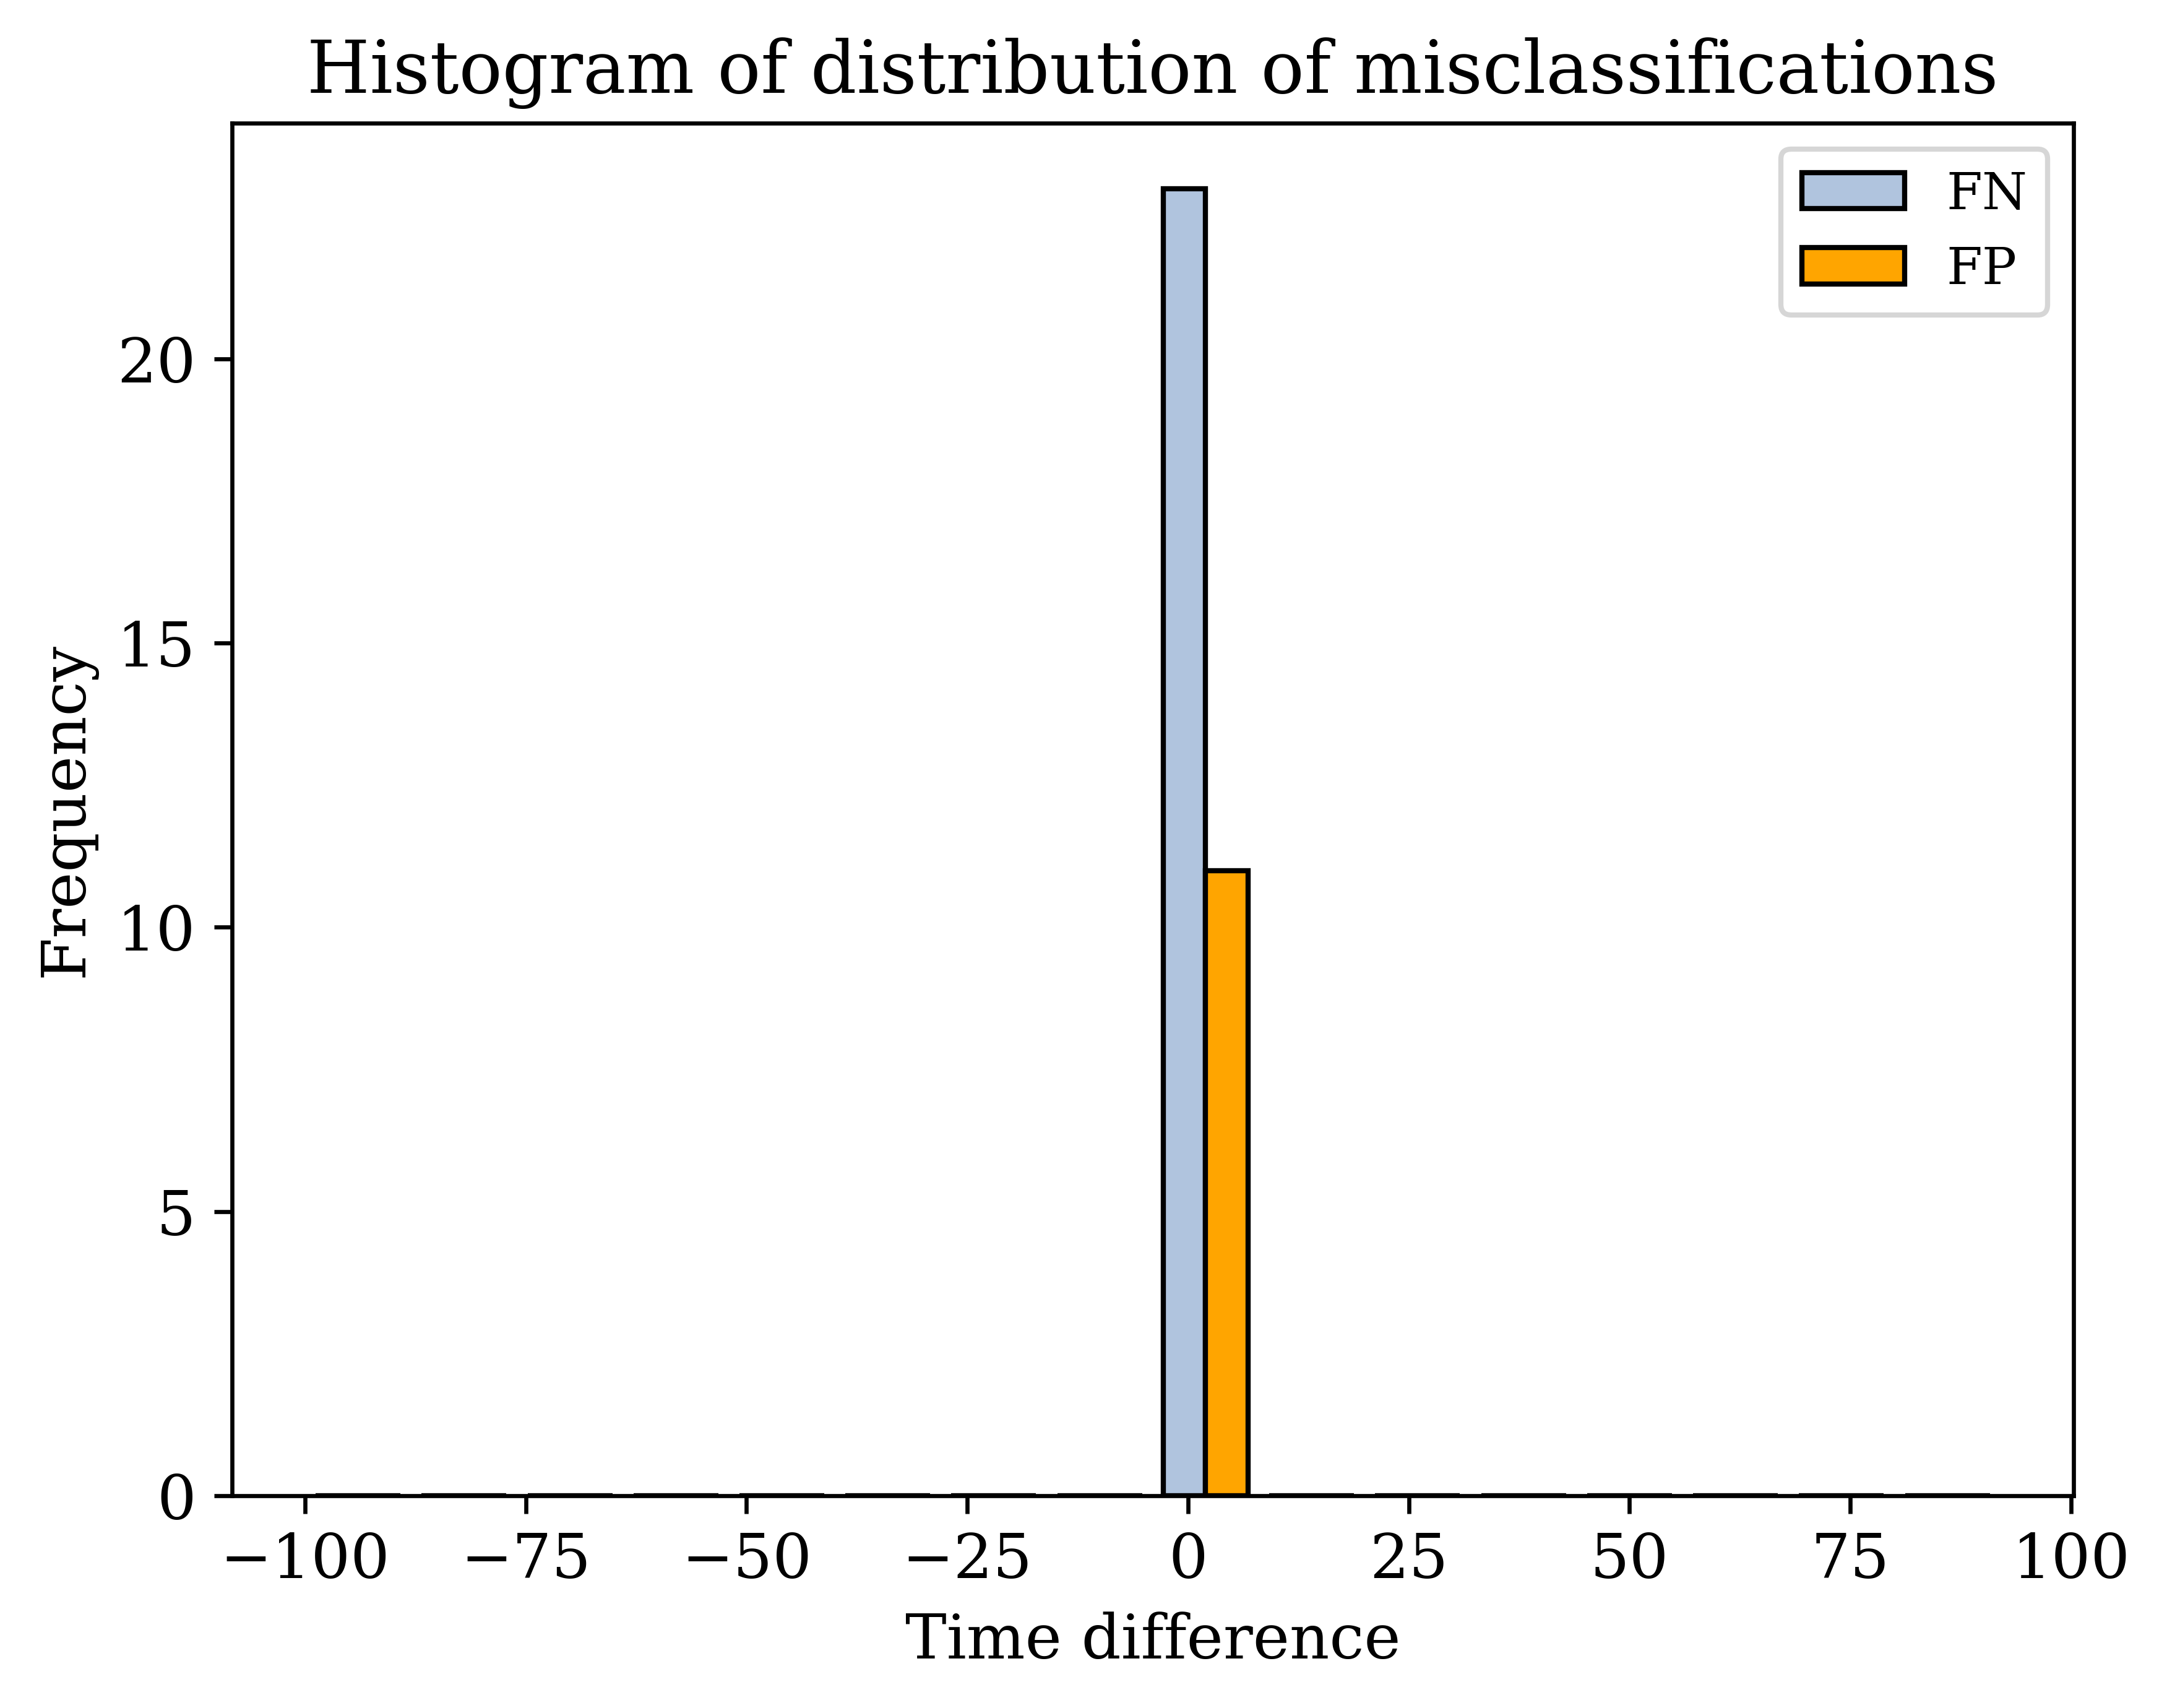

In [161]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/SPA_extra_all_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [162]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_39050/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_39050/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

cut  0.01  0.1  1  10  100  TO
FP      1    5  5   0    0   0
FN      4   12  6   1    0   0

#### Statistical tests

In [163]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [164]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
2208           0           0  STATS        039-117-augA1           orig   
2169           0           0  STATS        035-020-augA1           orig   
446            0           0  STATS  052-029-augF1-full1           orig   
259            0           0  STATS  030-092-augF2-full3           orig   
2078           0           0  STATS  027-132-augF1-augA4           orig   

      orig(med)  rewr(med)  0ma  #joins  total cost  ...  \
2208   0.555946   0.592231    1       3    18501.71  ...   
2169   0.351161   0.487759    1       2    11608.29  ...   
446    0.170633   0.406940    0       3    13670.43  ...   
259    0.143726   0.459312    0       2    11605.65  ...   
2078   0.348640   0.473003    1       4   288699.96  ...   

      median(container counts)  q75(container counts)  min(branching factors)  \
2208                       1.0                    1.0                       3   
2169                       1.0                    1.0                       2   
446                        1.0                    1.0                       3   
259                        1.0                    1.0                       2   
2078                       1.0                    1.0                       4   

      max(branching factors)  mean(branching factors)  \
2208                       3                      3.0   
2169                       2                      2.0   
446                        3                      3.0   
259                        2                      2.0   
2078                       4                      4.0   

      median(branching factors)  q25(branching factors)  \
2208                        3.0                     3.0   
2169                        2.0                     2.0   
446                         3.0                     3.0   
259                         2.0                     2.0   
2078                        4.0                     4.0   

      q75(branching factors)  diff rewr-orig  pred(med)  
2208                     3.0        0.036284   0.555946  
2169                     2.0        0.136598   0.351161  
446                      3.0        0.236307   0.170633  
259                      2.0        0.315586   0.143726  
2078                     4.0        0.124362   0.348640  

[5 rows x 37 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [165]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 228.0
P-value: 4.047650797773127e-25


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [166]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 6.798324273136121
P-value: 3.424969097193467e-11


#### Important features using Gini importance

In [167]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

0ma    #joins  total cost  min(table rows)  max(table rows)  \
Importance  0.108741  0.096514    0.301179          0.02415         0.043489   

            mean(table rows)  q25(table rows)  median(table rows)  \
Importance          0.023287         0.030378            0.012908   

            q75(table rows)  min(join rows)  ...  mean(container counts)  \
Importance         0.023594        0.041761  ...                0.033897   

            q25(container counts)  median(container counts)  \
Importance                    0.0                       0.0   

            q75(container counts)  min(branching factors)  \
Importance                    0.0                0.007321   

            max(branching factors)  mean(branching factors)  \
Importance                0.007174                  0.00852   

            median(branching factors)  q25(branching factors)  \
Importance                    0.00096                0.009976   

            q75(branching factors)  
Importance                0.003215  

[1 rows x 28 columns]

In [168]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
total cost                   0.301179
0ma                          0.108741
#joins                       0.096514
max(join rows)               0.057505
median(join rows)            0.047332
q25(join rows)               0.045947
max(table rows)              0.043489
min(join rows)               0.041761
mean(container counts)       0.033897
mean(join rows)              0.032371
q75(join rows)               0.032203
q25(table rows)              0.030378
min(table rows)              0.024150
q75(table rows)              0.023594
mean(table rows)             0.023287
median(table rows)           0.012908
q25(branching factors)       0.009976
mean(branching factors)      0.008520
min(branching factors)       0.007321
max(branching factors)       0.007174
depth                        0.006902
q75(branching factors)       0.003215
median(branching factors)    0.000960
max(container counts)        0.000674
q75(container counts)        0.000000
median(container counts)     0.000000
min(container counts)        0.000000
q25(container counts)        0.000000

#### Visualization of the decision tree

In [169]:
clf.tree_.max_depth

20

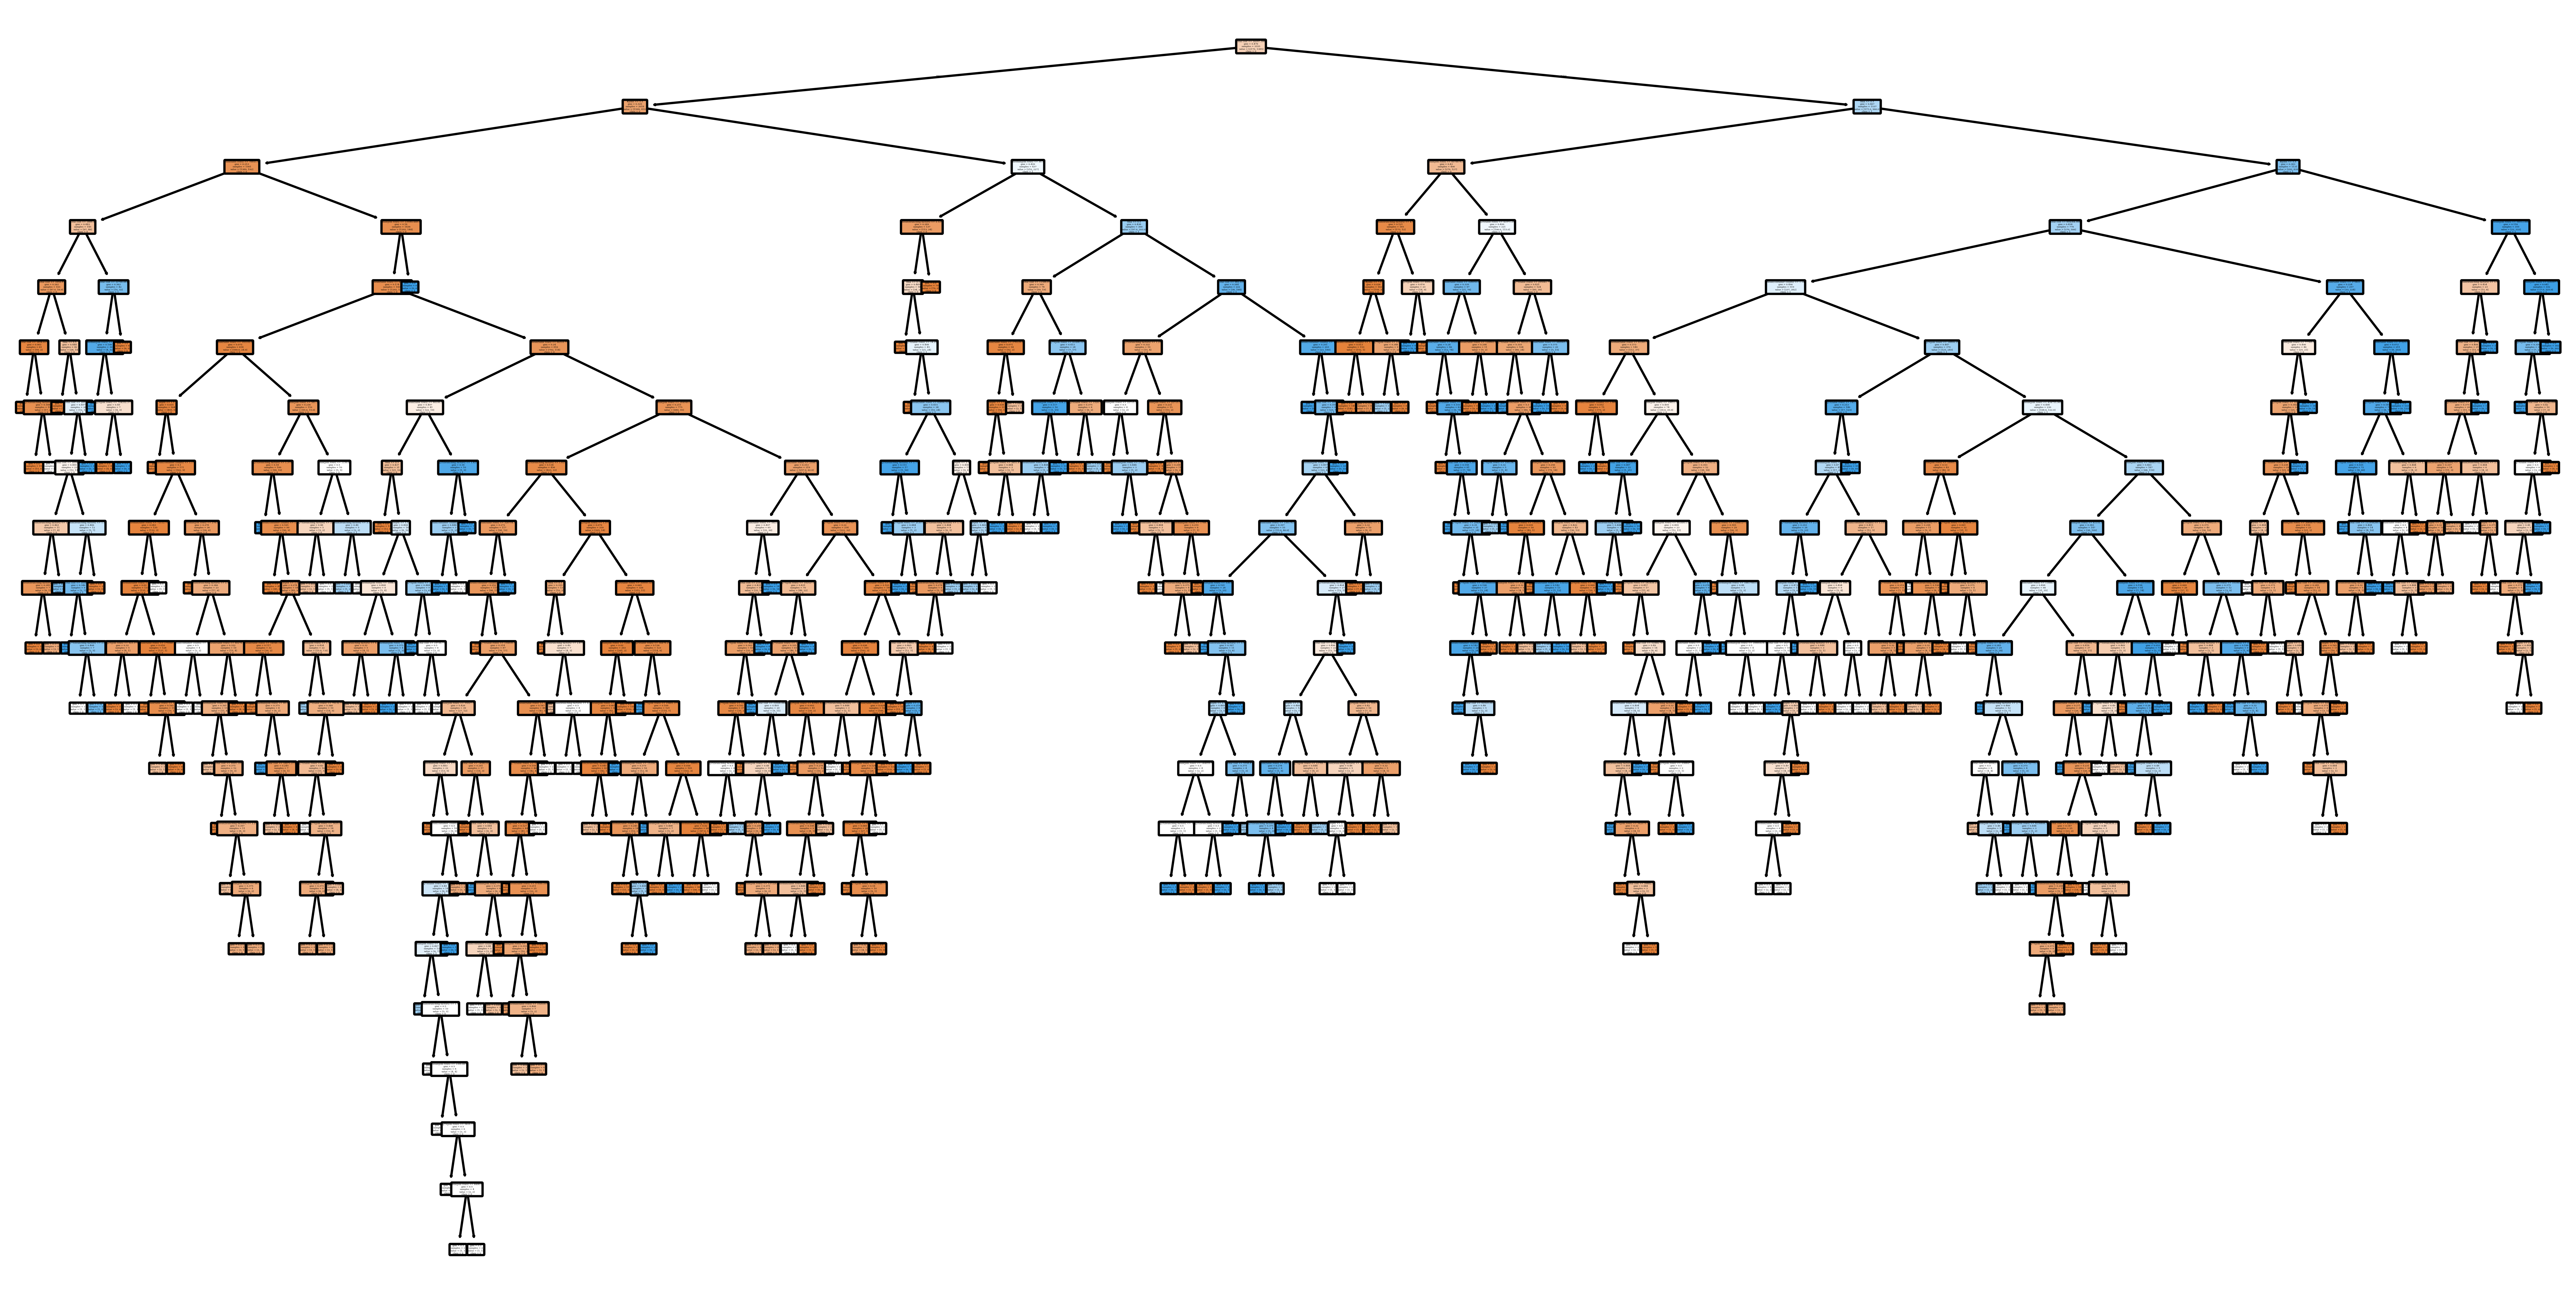

In [170]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/SPA_extra_all_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_39050/3149220611.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/3149220611.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/3149220611.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

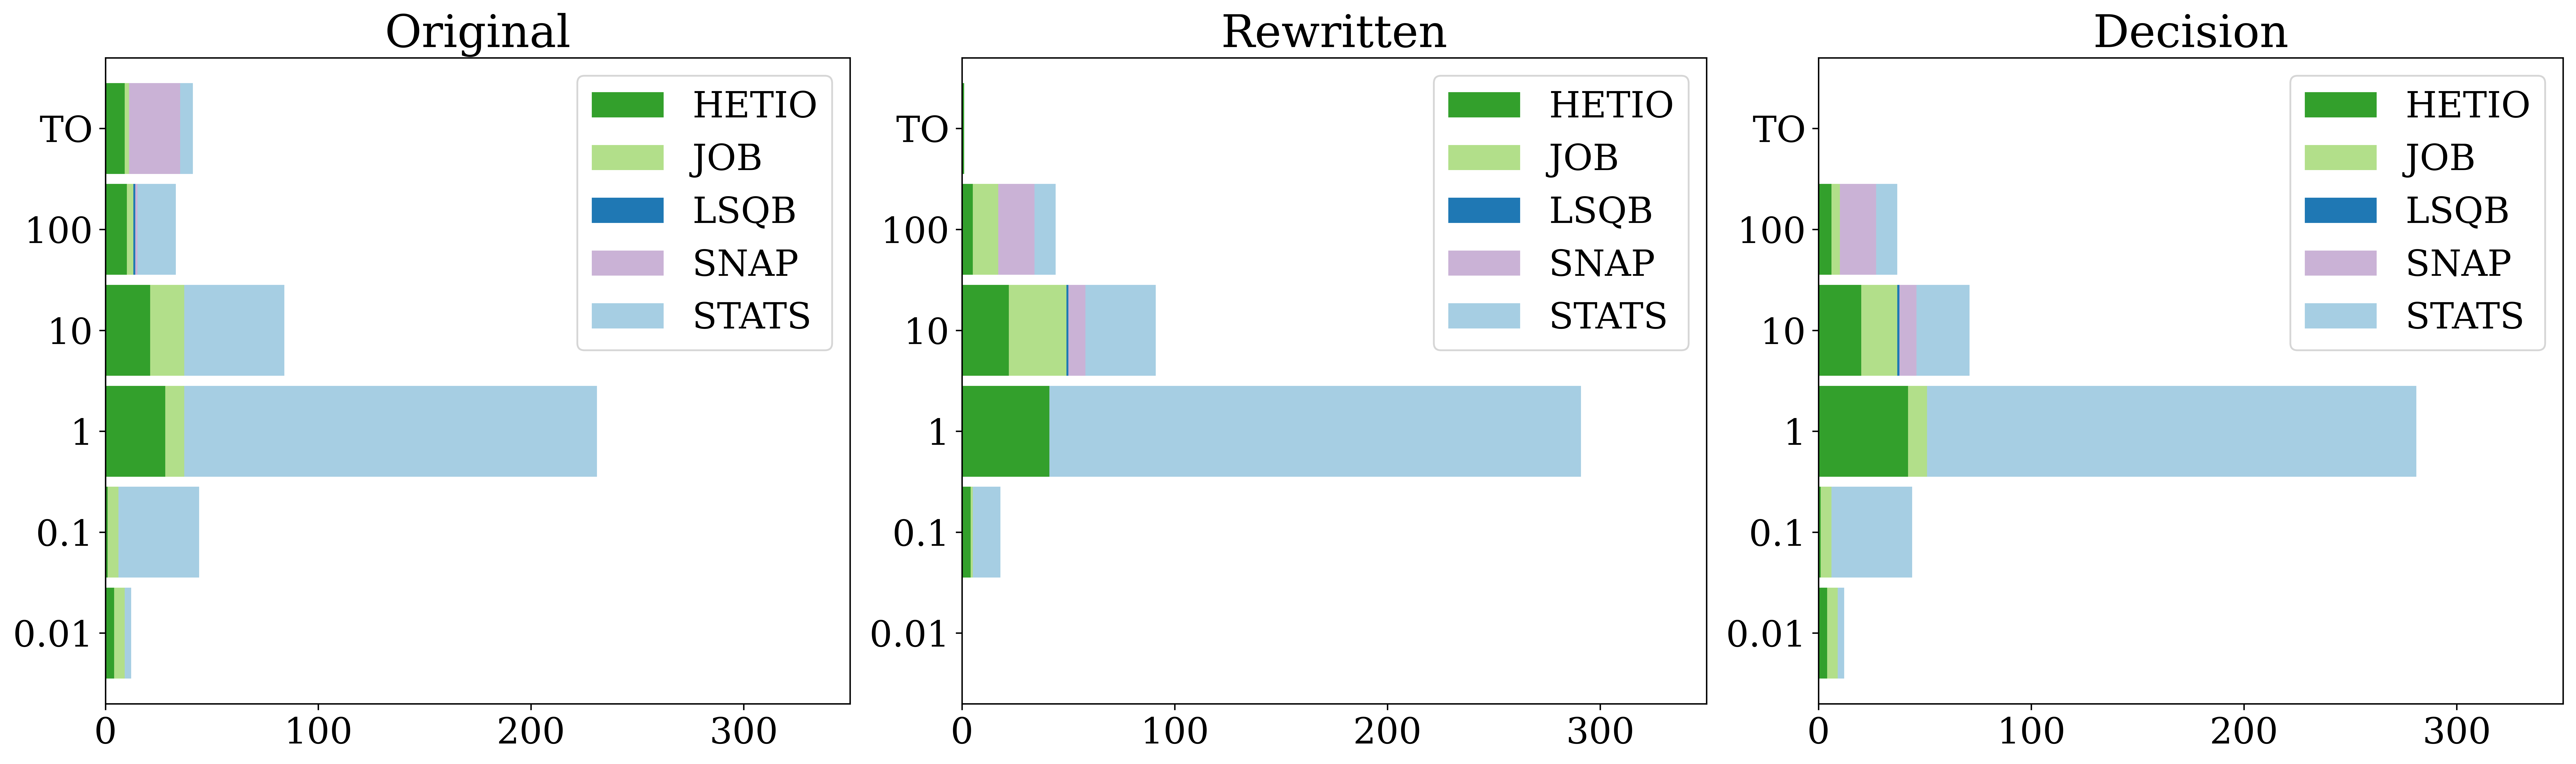

In [171]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_all_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_39050/1318828689.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/1318828689.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/1318828689.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

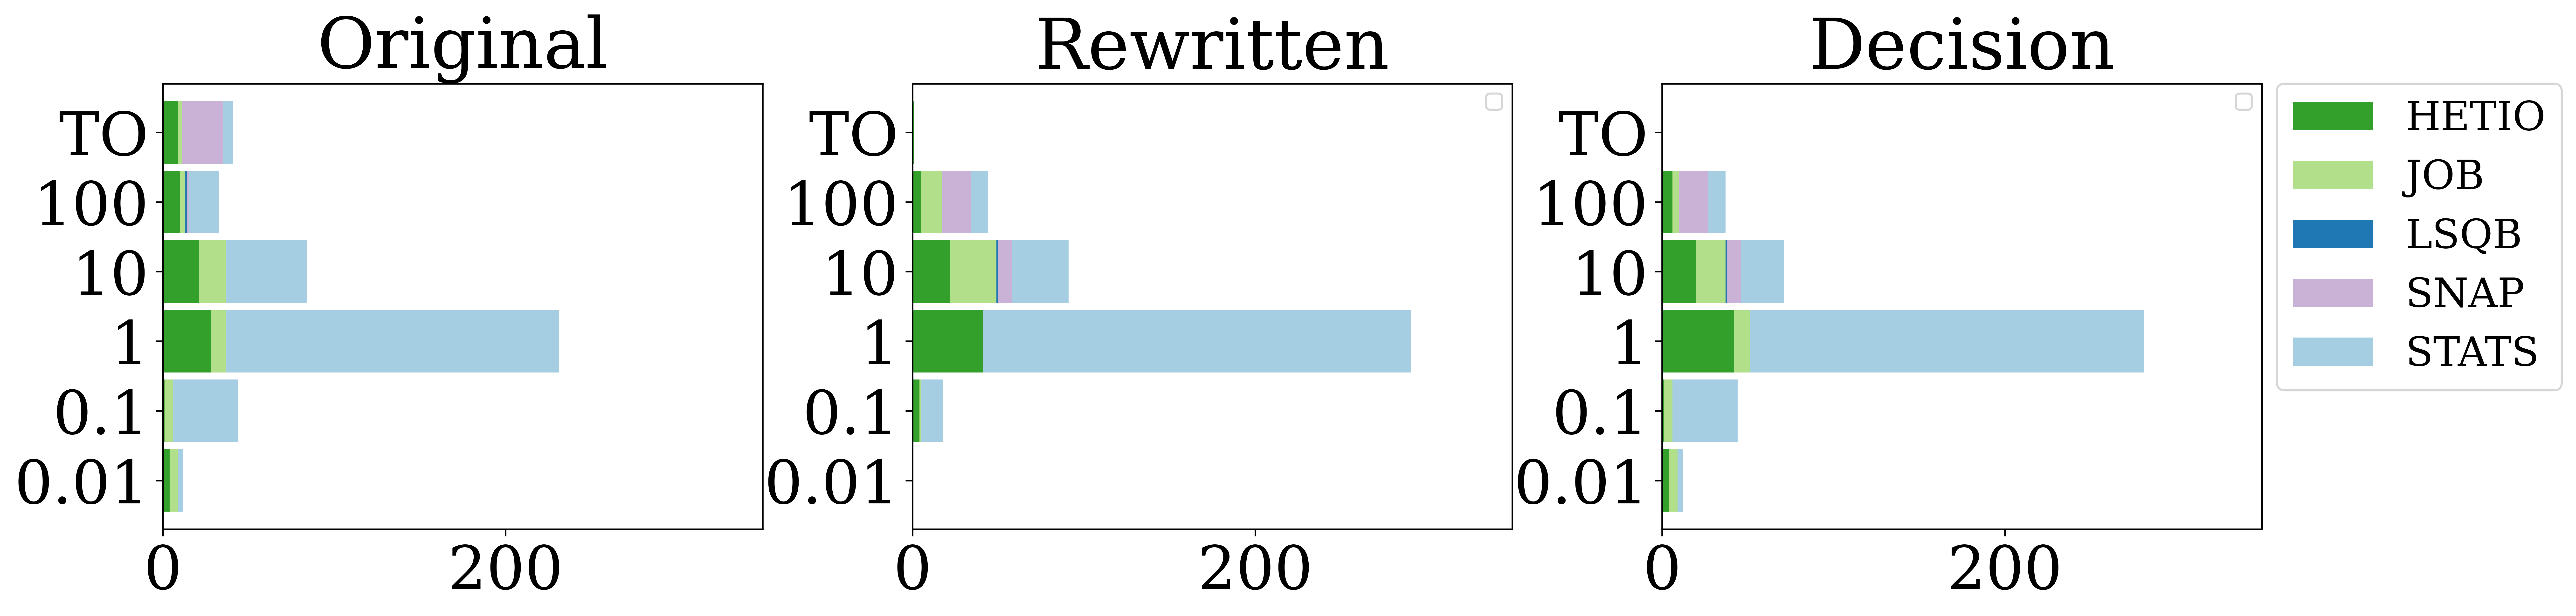

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/SPA_extra_all_runtimes_color.png') 
plt.show()


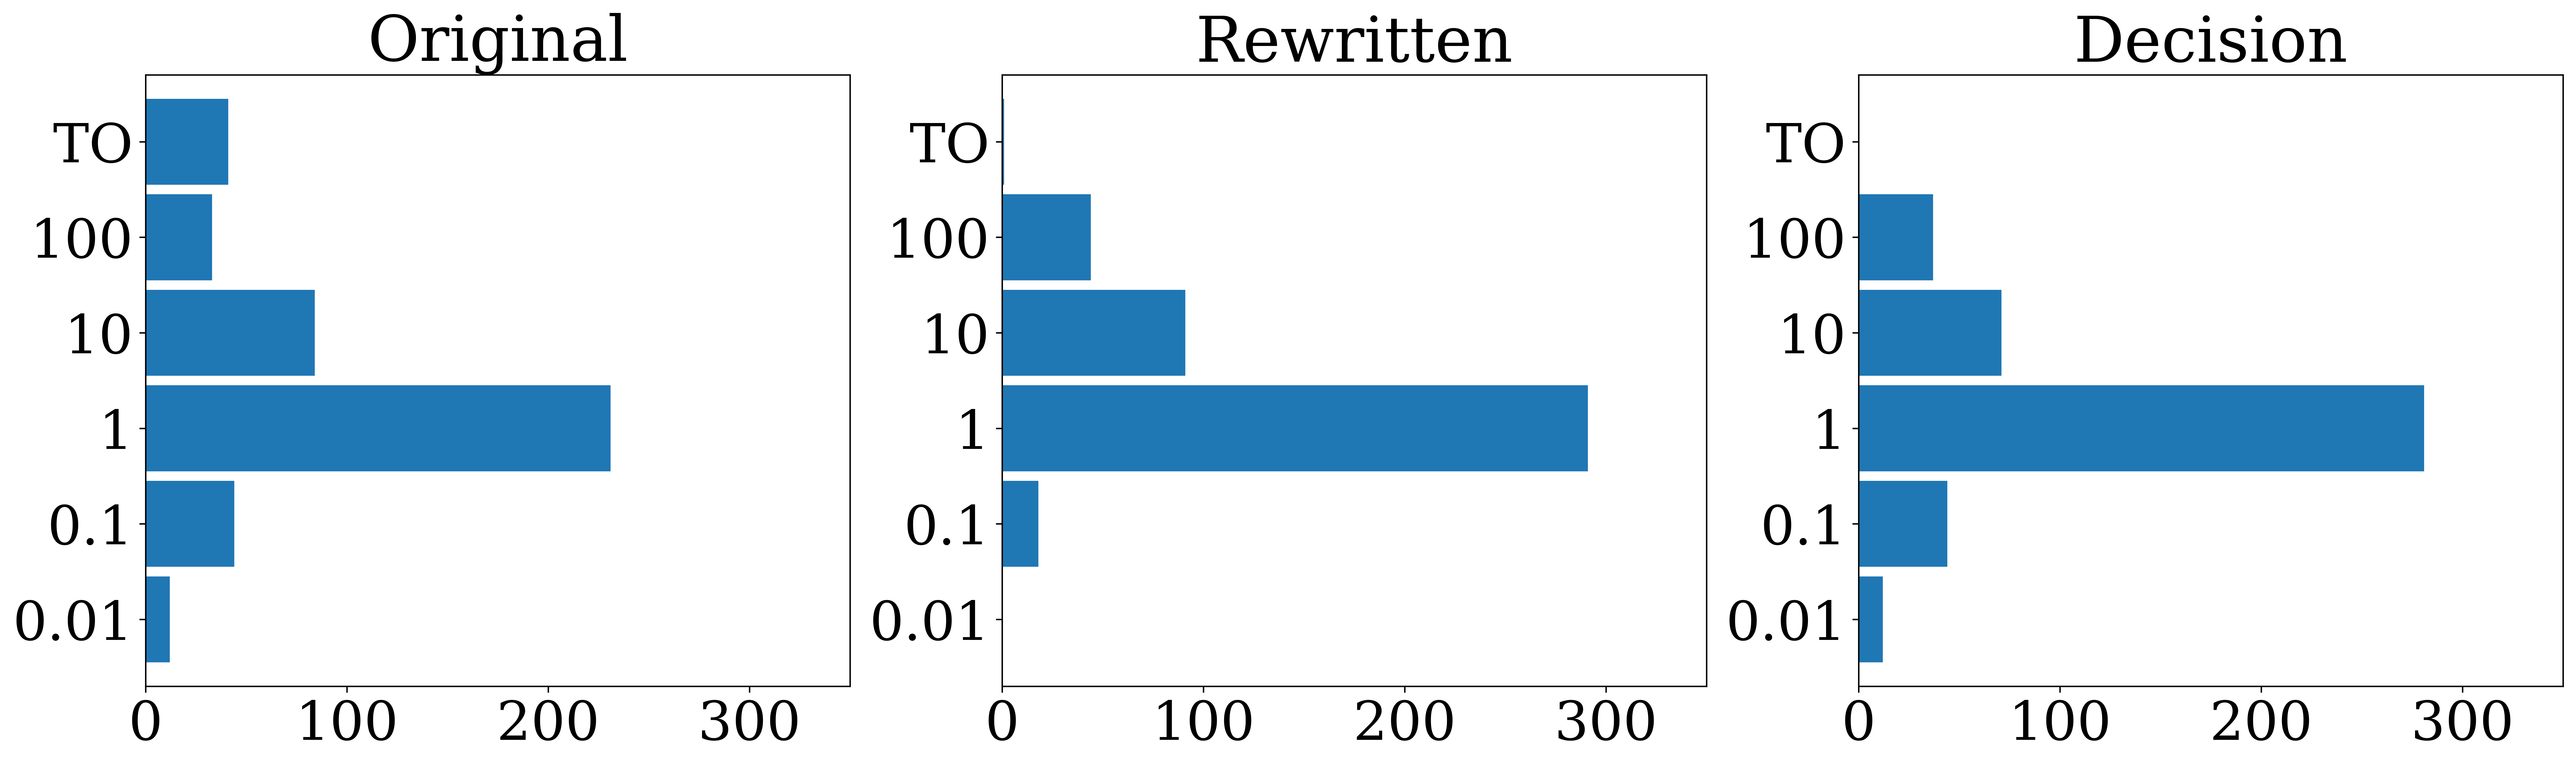

In [173]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_all_runtimes.png')
plt.show()